# Set up notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging

# Configure logging for ActivationDataset to show info level messages
logger = logging.getLogger("ActivationDataset")
logger.setLevel(logging.INFO)

# Create a console handler if one doesn't exist
if not logger.handlers:
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")
model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Lla

# Initialize the dataset and perform preprocessing

In [ ]:
import os

import pyarrow.compute as pyarrow_compute

from backtracking.dataset.open_math import OpenMathDataset
from backtracking.dataset.storage import StorageType, set_cache_dirs

# Change these to relevant paths for your setup (or if you want, set the corresponding env vars).
# The main one is the PERSISTENT_CACHE_DIR; ideally this is a location that will persist between
# instances of your notebook, eg a RunPod Network Volume.
set_cache_dirs(
    {
        StorageType.persistent: os.getenv("PERSISTENT_CACHE_DIR", "/workspace"),
        StorageType.temporary: os.getenv("TEMPORARY_CACHE_DIR", "/tmp/spar_data"),
        StorageType.ephemeral: os.getenv("EPHEMERAL_CACHE_DIR", "/tmp/spar_temp"),
    }
)

# This will initialize a dataset from the Huggingface Hub with the given name and revision ID.
# The line after this will perform some pre-processing and save it to local directories as a
# collection of PyArrow datasets (backed by Parquet files).
dataset = OpenMathDataset(
    "open-r1/OpenR1-Math-220k",
    "e4e141ec9dea9f8326f4d347be56105859b2bd68",
    model,
    tokenizer,
)

# This will load any stages that have already been processed from persistent cache, and run any stages
# that can't be found. Options can be tweaked per the comments.
dataset.run_pipeline(
    ## Prevent any computation from being run at all, useful if you're paranoid about accidentally wiping
    ## out a previous run.
    # reprocess_on_load_failure=True,
    #################################
    ## Force a re-run of the listed stages
    # reprocess_stages=["match"],
    #############################
    ## Only run on the first n rows of each stage
    # process_head = 100,
    #####################
)

# Pre-processed data is available as dataset.raw, dataset.token, and dataset.match. PyArrow dataset operations
# can be performed with memory-mapping to avoid loading the entire thing in memory. You can load a subset of
# the dataset into memory as a list of dicts with a convenience __getitem__ wrapper, as in the below.
dataset.match.filter(
    pyarrow_compute.field("match_type") == "backtracking_candidate",
)[:3]

[{'raw_row_id': 0,
  'token_row_id': 0,
  'match_type': 'backtracking_candidate',
  'context': 'he first journey.\n\nWait, actually, the ',
  'prefix_text': '.\n\n',
  'prefix_token_range': [353, 354],
  'match_text': 'Wait',
  'match_token_range': [354, 355],
  'suffix_text': '',
  'suffix_token_range': [355, 355],
  'match_row_id': 10},
 {'raw_row_id': 1,
  'token_row_id': 1,
  'match_type': 'backtracking_candidate',
  'context': 'al hours per day.\n\nWait, the problem sa',
  'prefix_text': '.\n\n',
  'prefix_token_range': [306, 307],
  'match_text': 'Wait',
  'match_token_range': [307, 308],
  'suffix_text': '',
  'suffix_token_range': [308, 308],
  'match_row_id': 21},
 {'raw_row_id': 1,
  'token_row_id': 1,
  'match_type': 'backtracking_candidate',
  'context': 'v" units per day. Wait, but actually, ',
  'prefix_text': '.',
  'prefix_token_range': [400, 401],
  'match_text': ' Wait',
  'match_token_range': [401, 402],
  'suffix_text': '',
  'suffix_token_range': [402, 402],
  'mat

# Run the model to collect activation data, or load this data from cache if already present

In [6]:
import pyarrow.compute as pyarrow_compute

from backtracking.dataset.open_math.activation_transform import Activation
from backtracking.dataset.storage import StorageType, load_dataset

# Get a sample of each backtracking cue
MIN_SAMPLE_SIZE = 100
target_class_names = (
    " Wait",
    "Wait",
    " No",
    "No",
    " Actually",
    "Actually",
)


def select_examples_to_run():
    from collections import defaultdict

    sample = defaultdict(list)
    for name in target_class_names:
        if len(sample[name]) >= MIN_SAMPLE_SIZE:
            continue
        for batch in dataset.match.scanner(
            columns=["token_row_id"],
            filter=(pyarrow_compute.field("match_type") == "backtracking_candidate")
            & (pyarrow_compute.field("match_text") == name),
        ).to_batches():
            sample[name].extend(
                batch["token_row_id"].to_pylist()[
                    0 : MIN_SAMPLE_SIZE - len(sample[name])
                ]
            )
            if len(sample[name]) >= MIN_SAMPLE_SIZE:
                break

    return sorted(list(set(sum((sample[name] for name in target_class_names), []))))


# Load the activations dataset if we've already processed it, otherwise process and save it.
# This takes about 20 minutes on a RunPod A40 instance with the sample set selected above. It will
# use about 6GB of space.
try:
    dataset.datasets["activation"] = load_dataset(
        StorageType.persistent, "demo_activations"
    )
except Exception:
    # Adding activations is still a bit manual at this point
    transform = Activation(
        model,
        tokenizer,
        dataset.match,
        storage_type=StorageType.persistent,
    )
    transform.run(
        dataset.token.take_dataset(select_examples_to_run()),
        "demo_activations",
        run_id=1,
    )
    dataset.datasets["activation"] = load_dataset(
        StorageType.persistent, "demo_activations"
    )


# Gather a sample for plots and steering

In [32]:
import re
from collections import defaultdict

from backtracking.ops import token_probs

baseline_activations = []
backtracking_activations = defaultdict(list)

MAX_SAMPLE_SIZE = 1_000


def include_target(name, act):
    probs = token_probs(target_class_names, act, model, tokenizer)
    if name == "Baseline":
        return sum(p[0] for p in probs.values()) < 0.05
    # Simple threshold
    return probs[name][0] >= 0.5


for batch in dataset.activation.batched_join(
    dataset.match,
    "match_row_id",
    self_projection=[re.compile(r"match_activations")],
    other_projection=["match_text", "match_type", "context"],
    other_filter=pyarrow_compute.field("match_type") == "sentence_start",
    limit=MAX_SAMPLE_SIZE - len(baseline_activations),
    progress_desc="Selecting baseline activations",
):
    baseline_activations.extend(
        b
        for b in batch.to_pylist()
        if include_target("Baseline", b["match_activations.31"])
    )

for name in target_class_names:
    for batch in dataset.activation.batched_join(
        dataset.match,
        "match_row_id",
        self_projection=[re.compile(r"match_activations")],
        other_projection=["match_text", "match_type", "context"],
        other_filter=(
            (pyarrow_compute.field("match_type") == "backtracking_candidate")
            & (pyarrow_compute.field("match_text") == name)
        ),
        limit=MAX_SAMPLE_SIZE - len(backtracking_activations[name]),
        progress_desc=f'Selecting "{name}" activations',
    ):
        backtracking_activations[name].extend(
            b
            for b in batch.to_pylist()
            if include_target(name, b["match_activations.31"])
        )


Selecting baseline activations:   0%|          | 0/12433 [00:00<?, ?it/s]

Selecting " Wait" activations:   0%|          | 0/12433 [00:00<?, ?it/s]

Selecting "Wait" activations:   0%|          | 0/12433 [00:00<?, ?it/s]

Selecting " No" activations:   0%|          | 0/12433 [00:00<?, ?it/s]

Selecting "No" activations:   0%|          | 0/12433 [00:00<?, ?it/s]

Selecting " Actually" activations:   0%|          | 0/12433 [00:00<?, ?it/s]

Selecting "Actually" activations:   0%|          | 0/12433 [00:00<?, ?it/s]

In [33]:
print(
    "Total baseline activations: ",
    len(baseline_activations),
)
print(
    "Total backtracking activations: ",
    sum(len(v) for k, v in backtracking_activations.items()),
)
print(
    "Backtracking activations by text: ",
    {k: len(v) for k, v in backtracking_activations.items()},
)

Total baseline activations:  918
Total backtracking activations:  1182
Backtracking activations by text:  {' Wait': 272, 'Wait': 656, ' No': 200, 'No': 42, ' Actually': 10, 'Actually': 2}


# Perform PCA on the collected sample

In [34]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

layers_to_run = range(len(model.model.layers))
pca_by_class = defaultdict(lambda: defaultdict(dict))
pca_transforms = {}
# Not big enough sample in demo for the other classes to get a nice plot, so don't use them for now
subset_class_names = ("Wait", " Wait")

# Balance classes
num_examples = min(
    len(t)
    for t in (
        baseline_activations,
        *tuple(backtracking_activations[n] for n in subset_class_names),
    )
)
print(
    f"Running PCA for classes {('Baseline',) + subset_class_names}\n    {num_examples} each"
    f"\n    layers {layers_to_run.start}--{layers_to_run.stop}"
)

for layer in layers_to_run:
    baseline = [
        a[f"match_activations.{layer}"][0, :]
        for a in baseline_activations[:num_examples]
    ]

    targets = tuple(
        [
            a[f"match_activations.{layer}"][0, :]
            for a in backtracking_activations[t][:num_examples]
        ]
        for t in subset_class_names
    )

    pca = PCA(n_components=2)
    pca_data = np.vstack((baseline, *targets))
    pca_result = pca.fit_transform(pca_data)
    pca_transforms[layer] = pca

    cur_offset = len(baseline)
    pca_by_class["Baseline"][layer] = pca_result[:cur_offset]
    for i, target_class in enumerate(subset_class_names):
        pca_by_class[target_class][layer] = pca_result[
            cur_offset : cur_offset + len(targets[i])
        ]
        cur_offset += len(targets[i])

Running PCA for classes ('Baseline', 'Wait', ' Wait')
    272 each
    layers 0--32


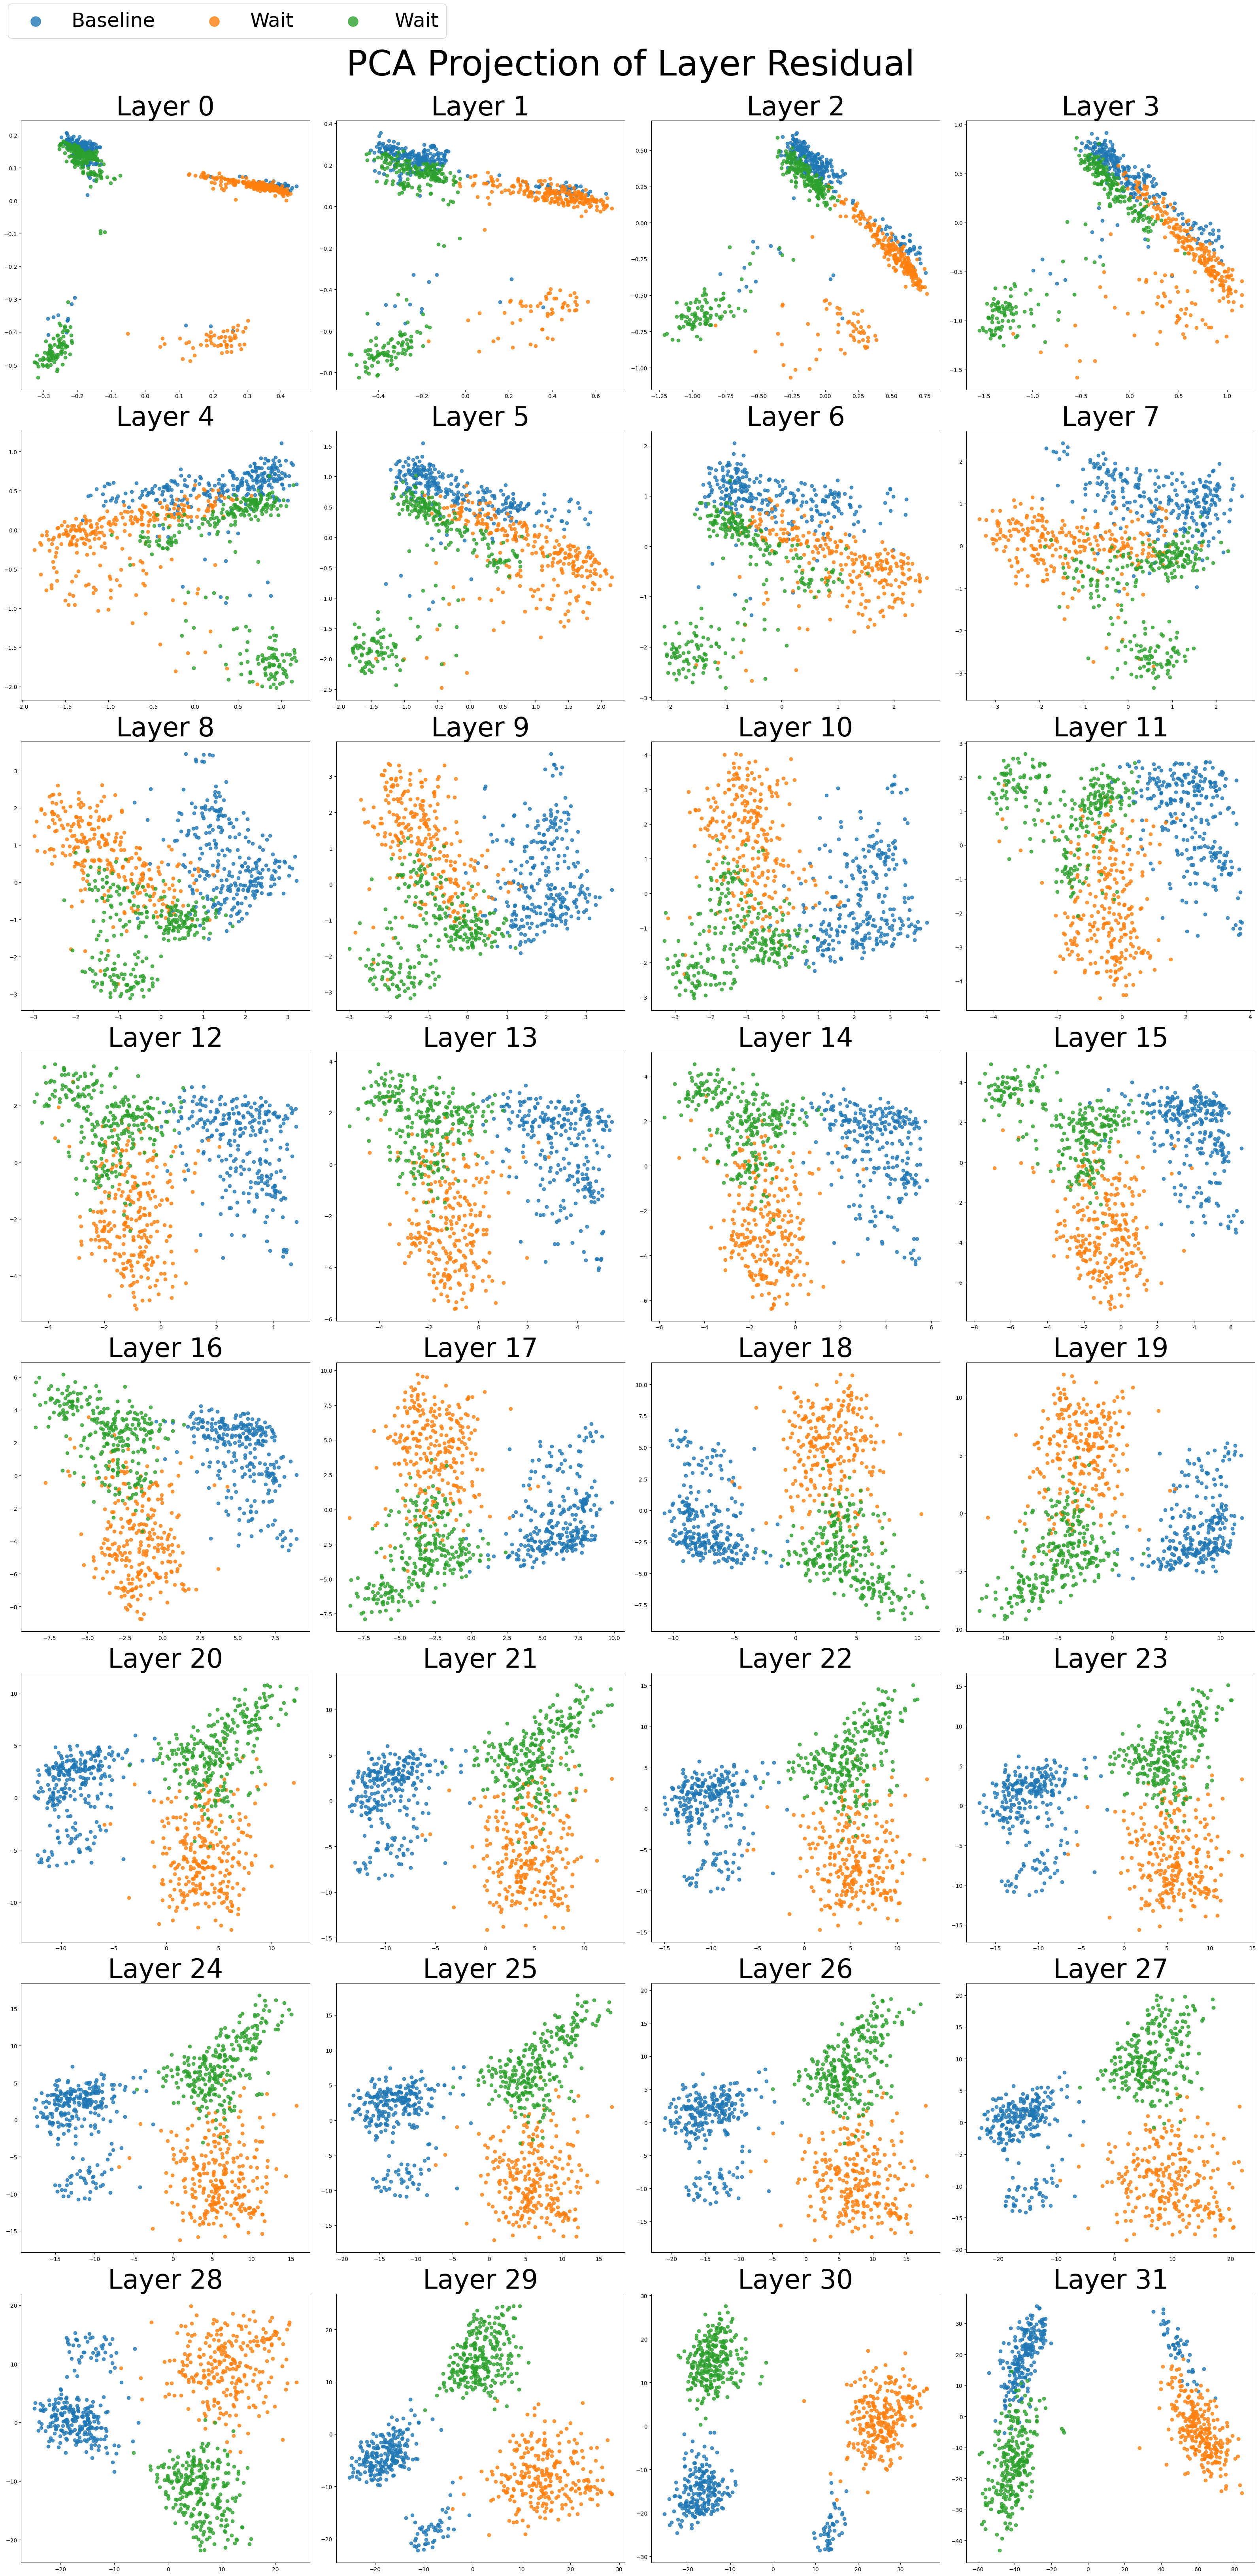

In [35]:
import matplotlib.pyplot as plt

layers_to_plot = range(layers_to_run.start, layers_to_run.stop)

num_layers = layers_to_plot.stop - layers_to_plot.start
num_rows = (num_layers + 3) // 4
fig, axes = plt.subplots(num_rows, 4, figsize=(32, 8 * num_rows))
axes = axes.flatten()

for layer in layers_to_plot:
    axis_index = layer - layers_to_plot.start
    for class_name, data in pca_by_class.items():
        axes[axis_index].scatter(
            data[layer][:, 0],
            data[layer][:, 1],
            label=class_name,
            alpha=0.8,
        )
    axes[axis_index].set_title(f"Layer {layer}", fontsize=48)

    if axis_index == 0:
        axes[axis_index].legend()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower left",
    fontsize=36,
    bbox_to_anchor=(
        0,
        1.0,
    ),
    markerscale=3.0,
    ncol=4,
)
axes[0].get_legend().remove()
fig.suptitle("PCA Projection of Layer Residual", fontsize=64, y=1)
# Hide any unused subplots
for i in range(num_layers, len(axes)):
    axes[i].axis("off")

fig.tight_layout()

plt.show()

# Generate steering vectors

In [139]:
import numpy


def mean_vector(acts, layer):
    return numpy.mean(
        numpy.vstack(
            tuple(a[f"match_activations.{layer}"][0, :] for a in acts),
            dtype=numpy.float64,
        ),
        axis=0,
    )


def combo_mean(class_names, existing_means):
    renorm = sum(len(backtracking_activations[name]) for name in class_names)
    return {
        layer: numpy.sum(
            numpy.vstack(
                # renormalize since class sizes are unequal
                tuple(
                    existing_means[name][layer]
                    * len(backtracking_activations[name])
                    / renorm
                    for name in class_names
                ),
                dtype=numpy.float64,
            ),
            axis=0,
        )
        for layer in layers_to_run
    }


mean_class = {
    name: {
        layer: mean_vector(backtracking_activations[name], layer)
        for layer in layers_to_run
    }
    for name in backtracking_activations.keys()
    if len(backtracking_activations[name]) > 0
}
mean_class["Baseline"] = {
    layer: mean_vector(baseline_activations, layer) for layer in layers_to_run
}

mean_class["all"] = combo_mean(backtracking_activations.keys(), mean_class)
mean_class["waits"] = combo_mean(["Wait", " Wait"], mean_class)

steering_vectors = {
    name: {
        layer: mean_class[name][layer] - mean_class["Baseline"][layer]
        for layer in layers_to_run
    }
    for name in mean_class
    if name != "Baseline"
}

# Compare with SAEs

In [143]:
from sae_lens import SAE
from torch import no_grad, tensor

from backtracking.ops import compare_activation

# TODO: plot all pairwise, on all layers
sae = SAE.from_pretrained("llama_scope_r1_distill", "l15r_800m_slimpajama")[0].to("cuda")
baseline = tensor(mean_class["Baseline"][15]).to("cuda")

for name in ["all", "Baseline"]:
    with no_grad():
        if name == "Baseline":
            vector = baseline
        else:
            vector = tensor(steering_vectors[name][15]).to("cuda")

    compare_activation(name, vector, sae)

Cosine similarity between deepseek-r1-distill-llama-8b/15-llamascope-slimpj-res-32k and "all"
Most correlated SAE features
  SAE feature 13291, cosine sim: 0.325107216127721
  SAE feature 13190, cosine sim: 0.31472287159861434
  SAE feature 9558, cosine sim: 0.1948949259963286
  SAE feature 822, cosine sim: 0.19040850726696087
  SAE feature 31723, cosine sim: 0.18213285660336995
  SAE feature 11549, cosine sim: 0.17674747025622928
  SAE feature 7116, cosine sim: 0.17081716934532307
  SAE feature 30482, cosine sim: 0.14815774526197015
  SAE feature 13703, cosine sim: 0.13968833392517127
  SAE feature 1563, cosine sim: 0.13621832504104386
Most anti-correlated SAE features
  SAE feature 8309, cosine sim: -0.3303458326876899
  SAE feature 24377, cosine sim: -0.24506394127788464
  SAE feature 4329, cosine sim: -0.2087946664762152
  SAE feature 8727, cosine sim: -0.20869735381395335
  SAE feature 30012, cosine sim: -0.20636931825666802
  SAE feature 4561, cosine sim: -0.19942596227602563
  S

# Generate text with steering

In [146]:
from backtracking.ops import generate
from backtracking.steering import SteeringFlag, add_steering_vector

# Toggle on/off, directional ablation mode, or tweak scale
steering = SteeringFlag(on=True, directional_ablation=False, scale=8)
with add_steering_vector(
    19, torch.tensor(steering_vectors["all"][19]), model, steering=steering
):
    example = dataset.token[655]
    prompt = example["prefill"][: example["prompt_len"]]
    print(prompt)
    try:
        generate(prompt, model, tokenizer)
    except KeyboardInterrupt:
        print("\n\n*** Generation aborted by user ***")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Let $a$ and $b$ be real numbers such that the two polynomials $x^{2}+a x+b$ and $x^{2}+b x+a$ each have two distinct real roots, and the polynomial $\left(x^{2}+a x+b\right)\left(x^{2}+b x+a\right)$ has three distinct real roots. What values can the sum of these three roots take? (All-Russian Olympiad 2015 Grade 9 Day 1 Problem 1)
Please reason step by step, and put your final answer within \boxed{}.

Wait, no, sorry, actually, the problem is in English, from the All-Russian Olympiad 2015, Grade 9 Day 1 Problem 1.

Wait, actually, the problem is: Let $a$ and $b$ be real numbers such that the two polynomials $x^2 + a x + b$ and $x^2 + b x + a$ each have two distinct real roots, and the polynomial $(x^2 + a x + b)(x^2 + b x + a)$ has three distinct real roots. What values can the sum of these three roots take? Or is it four roots? Wait, no, no, wait, wait.

Wait, actually, the polynomial is $(x^2 + a x + b)(x^2 + b x + a)$, which is of degree 4, so it has four roots. But the problem says